# Yambda Dataset Exploration

In this notebook we will dive into Yambda dataset, exploring its distribution, and looking at some sampled examples. We will try to gain insights about the data by visualizing and calculating statistics

Importing required libraries

In [1]:
from typing import Literal
from datasets import Dataset, DatasetDict, load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from collections import defaultdict
import numpy as np
from networkx.algorithms import bipartite
import random

## Yambda Dataset Class

In the [hugging face page of the dataset ](https://huggingface.co/datasets/yandex/yambda) authors suggest to define a specific class for the ease of use. We will follow the instructions

In [2]:
class YambdaDataset:
  # Basically enumerating all possible interactions in the dataset
  INTERACTIONS = frozenset(["likes", "listens", "multi_event", "dislikes", "unlikes", "undislikes"])

  def __init__(
      self,
      dataset_type: Literal["flat", "sequential"] = "flat",
      dataset_size: Literal["50m", "500m", "5b"] = "50m"
  ):
    # Initialize the instance of the dataset with two parameters: its type
    # and size
    assert dataset_type in {"flat", "sequential"}
    assert dataset_size in {"50m", "500m", "5b"}
    self.dataset_type = dataset_type
    self.dataset_size = dataset_size

  def interaction(self, event_type: Literal["likes", "listens", "multi_event", "dislikes", "unlikes", "undislikes"]) -> Dataset:
    # This function will retrieve us needed table for our interaction type.
    assert event_type in self.INTERACTIONS
    return self._download(f"{self.dataset_type}/{self.dataset_size}", event_type)

  def audio_embeddings(self) -> Dataset:
    # Retrieve audio embeddings
    return self._download("", "embeddings")

  def album_item_mapping(self) -> Dataset:
    # Retrieve album item mapping
    return self._download("", "album_item_mapping")

  def artist_item_mapping(self) -> Dataset:
    # Retrieve artist item mapping
    return self._download("", "artist_item_mapping")

  @staticmethod
  def _download(data_dir: str, file: str) -> Dataset:
    # Function for downloading the needed part of the dataset.
    data = load_dataset("yandex/yambda", data_dir=data_dir, data_files=f"{file}.parquet")
    assert isinstance(data, DatasetDict)
    return data["train"]



## Exploring Data Distribution and Statistics

Let's download the needed table. Since we are students with limited resources, we will mostly work with 50m version of the dataset.

In [3]:
dataset = YambdaDataset("flat", "50m")
listens = dataset.interaction("listens")
likes = dataset.interaction("likes")
dislikes = dataset.interaction("dislikes")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Move everything to pandas dataframe

In [4]:
listens_df = listens.to_pandas()
likes_df = likes.to_pandas()
dislikes_df = dislikes.to_pandas()

Let's calculate general statistics about 50m version of the dataset
- Number of unique users
- Number of unique items
- Number of interactions between users and items

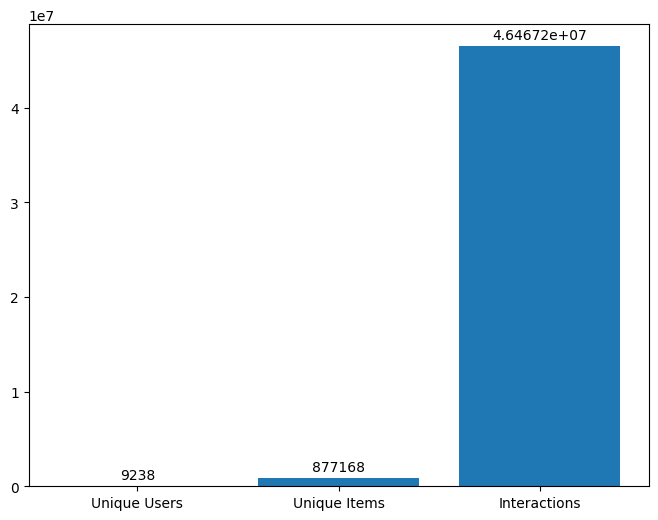

In [5]:
number_of_unique_uid = listens_df["uid"].nunique()
number_of_unique_item_id = listens_df["item_id"].nunique()
number_of_interactions = listens_df.shape[0]

categories = ["Unique Users", "Unique Items", "Interactions"]
values = [number_of_unique_uid, number_of_unique_item_id, number_of_interactions]

fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(categories, values)
ax.bar_label(bars, padding=3)
plt.show()

Let's examine the distribution of the `is_organic` flag. According to the dataset documentation, when `is_organic = 1`, the interaction originates from the user themselves, not from Yandex's recommendation system.

* **Example of an organic interaction**: The user learns about a song via external sources (friends, TV, etc.), and then searches for it on Yandex.Music. Because the recommendation system didn't prompt the user to listen, this counts as organic (`is_organic = 1`).
* **Example of a recommendation-driven interaction**: The user opens the app and clicks on “My Vibe,” which presents tracks suggested by Yandex.Music's recommendation algorithms. Such interactions have `is_organic = 0`.

Distinguishing between natural user actions and those driven by recommendations is a key advantage of this dataset. It allows researchers and engineers to separate truly organic behavior from recommendation-influenced behavior when analyzing the data.


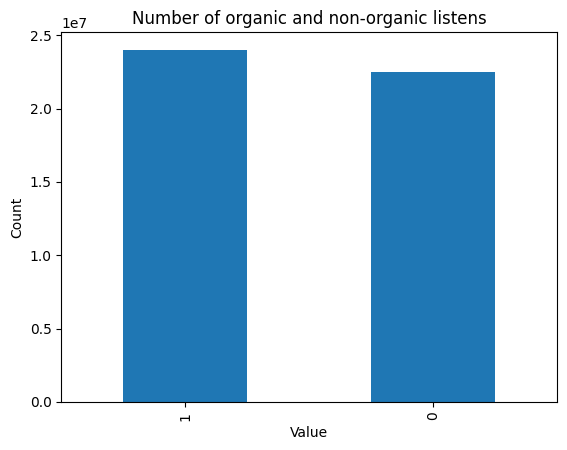

In [6]:
listens_df["is_organic"].value_counts().plot(kind="bar", title="Number of organic and non-organic listens")
plt.xlabel("Value")
plt.ylabel("Count")
plt.show()


Let's explore the distribution of likes and dislikes in this dataset. We will also look at how much of these interactions were produced by the recommendation systems, and how much are natural

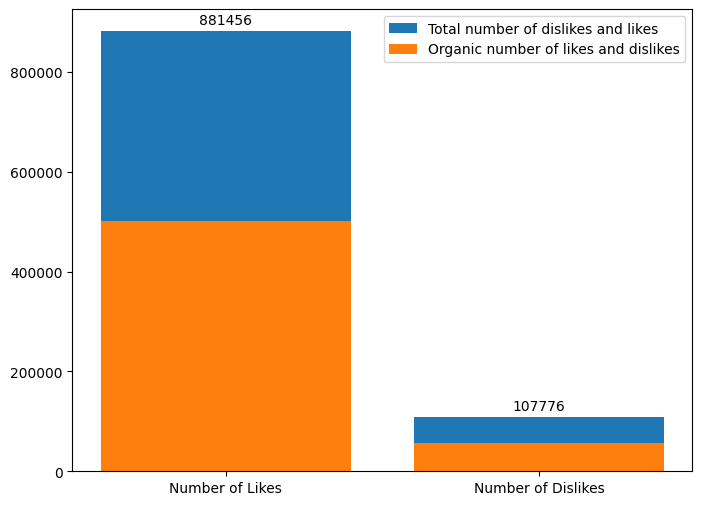

In [7]:
categories = ["Number of Likes", "Number of Dislikes"]
values = [likes_df.shape[0], dislikes_df.shape[0]]
organics = [likes_df["is_organic"].sum(), dislikes_df["is_organic"].sum()]

fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(categories, values, label = "Total number of dislikes and likes")
bars2 = ax.bar(categories, organics, label ="Organic number of likes and dislikes")
ax.bar_label(bars1, padding=3)
ax.legend()
plt.show()


Let's explore how many distinct users interacted with each item.  
Read the plot like: **“1,000 items have interactions from 500 users”** or **“5 items have interactions from 1,000,000 users.”**

**What to notice**
- The distribution is heavily **right-skewed** (long tail): most items receive very few interactions, while a small set of items receives many.  
- The bulk of items cluster near zero interactions; a small minority accounts for a large share of user activity.  


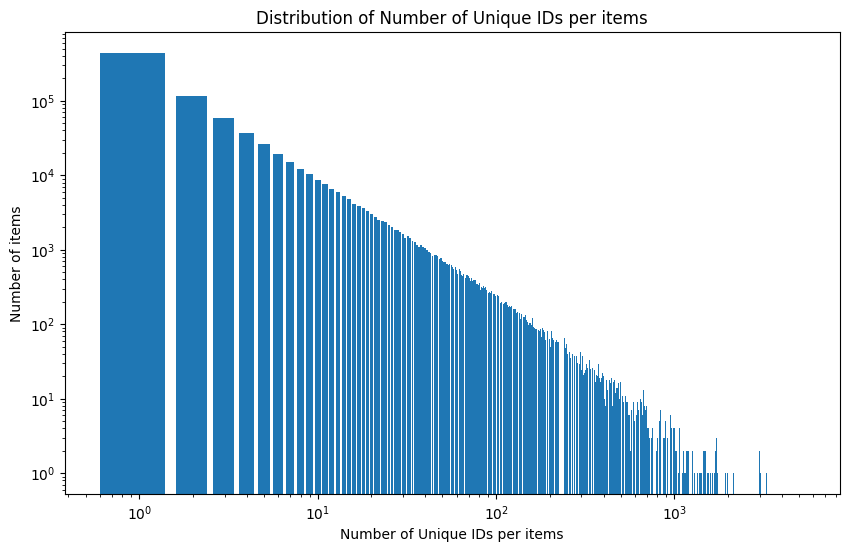

In [8]:
# For each item we want to count the number of users interacted with it
per_item_distribution = listens_df.groupby("item_id").agg({"uid": "nunique"}).reset_index()
# Then we have a table where we have item_id, and number of interactions with it
# Let's explore the distribution of count - groupby the "uid" which is the count,
# and explore how much item's has this count. So for example
# If item x_k and x_j had interaction with 3 users, we will make this as
# 3 | 2, so two two items had 3 interactions with users. In table it will be
hist_data = per_item_distribution.groupby("uid").size().reset_index(name="items_count")

plt.figure(figsize=(10, 6))
plt.bar(hist_data["uid"], hist_data["items_count"])
plt.xlabel("Number of Unique IDs per items")
plt.ylabel("Number of items")
plt.title("Distribution of Number of Unique IDs per items")
plt.xscale('log')
plt.yscale('log')
plt.show()


Let's explore the distribution of played ratio percentage using histplot. We can see that most of the users either almost don't listen the track, or listen it fully

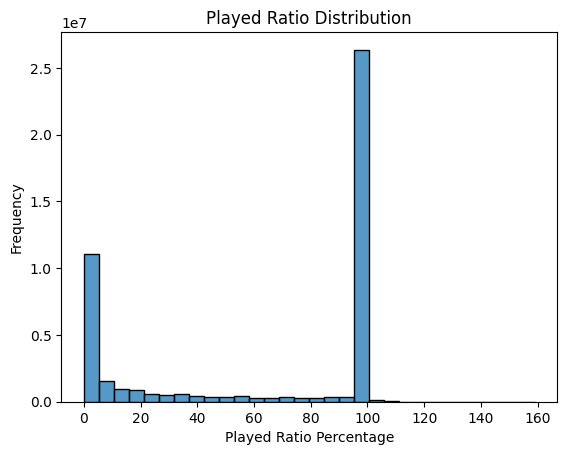

In [9]:
sns.histplot(listens_df["played_ratio_pct"], bins=30)

plt.xlabel("Played Ratio Percentage")
plt.ylabel("Frequency")
plt.title("Played Ratio Distribution")
plt.show()

## Exploring the User-Item Relationships with Graphs

Let's try to visualize the interacitons using graph. In recommendation systems, it's convenient to visualize the relationships using bipartite graphs. We will do the same

In [10]:
# Sample only 50k interactions from the dataset
sampled_listens_df = listens_df.sample(frac=0.001)

In [11]:
# Create a graph and add nodes
# On the left we will have users
# On the right we will have items
B = nx.Graph()

users = sampled_listens_df["uid"].unique()
items = sampled_listens_df["item_id"].unique()
B.add_nodes_from(users, bipartite="user")
B.add_nodes_from(items, bipartite="item")


In [12]:
# One pair of (uid, item_id) could have many interactions. But in our bipartite graph
# We can have only one connection. Therefore, we will aggregate all of these
# Connections between the same pair, to create only one link. This link will be
# Weighted by the number of interactions.
agg = sampled_listens_df.groupby(["uid", "item_id"]).agg(
    n_listens=("uid", "count"),
    mean_play=("played_ratio_pct", "mean"),
    is_organic=("is_organic", "max"),
    first_ts=("timestamp", "min"),
    last_ts=("timestamp", "max"),
).reset_index()

In [13]:
# Add the edges we composed
B.add_edges_from(
    (row.uid, row.item_id, dict(
      n_listens=int(row.n_listens),
      mean_play=float(row.mean_play),
      is_organic=int(row.is_organic),
      first_ts=row.first_ts,
      last_ts=row.last_ts
    ))
    for _, row in agg.iterrows()
)

In [14]:
# Also add the propety of liked or disliked. We will color connection using this property then
liked = set(zip(likes_df["uid"], likes_df["item_id"]))
disliked = set(zip(dislikes_df["uid"], dislikes_df["item_id"]))
for (u, i) in set(B.edges()):
  B[u][i]["liked"] = int((u, i) in liked)
  B[u][i]["disliked"] = int((u, i) in disliked)


In [15]:
# Our graph still have a lot of nodes and interactions. To make visualization
# We will sample only tiny part of the graph
def sample_user_item_subgraph(B, n_users):
  U = [n for n, d in B.nodes(data=True) if d["bipartite"] == "user"]
  U = set(random.sample(U, min(len(U), n_users)))
  I = set().union(*[set(B.neighbors(u)) for u in U])
  return B.subgraph(U | I).copy()


In [16]:
# Create our sub-sampled graph with only 5 users and their's items
S = sample_user_item_subgraph(B, 5)

In [18]:
# Extract nodes
U = [n for n, d in S.nodes(data=True) if d['bipartite'] == "user"]
I = [n for n, d in S.nodes(data=True) if d['bipartite'] == "item"]

In [19]:
# Make bipartite layour for the graph
pos = nx.bipartite_layout(S, nodes=U)

In [20]:
# Add node color depending on its type (user or item)
# Also add node size depending on its degree
node_color = ["tab:orange" if n in U else "tab:blue" for n in S.nodes()]
node_size = [max(30, 10*np.sqrt(S.degree(n))) for n in S.nodes()]

In [21]:
# Function to determine the edge width
def edge_width(u, v):
  w = S[u][v].get("n_listens", 1)
  return 1 + np.log1p(w)

In [22]:
# Determine the width of edges and their colors
edge_w = [edge_width(u, v) for u, v in S.edges()]
edge_c = ["tab:green" if S[u][v]["liked"]==1 else "tab:red" for u, v in S.edges()]

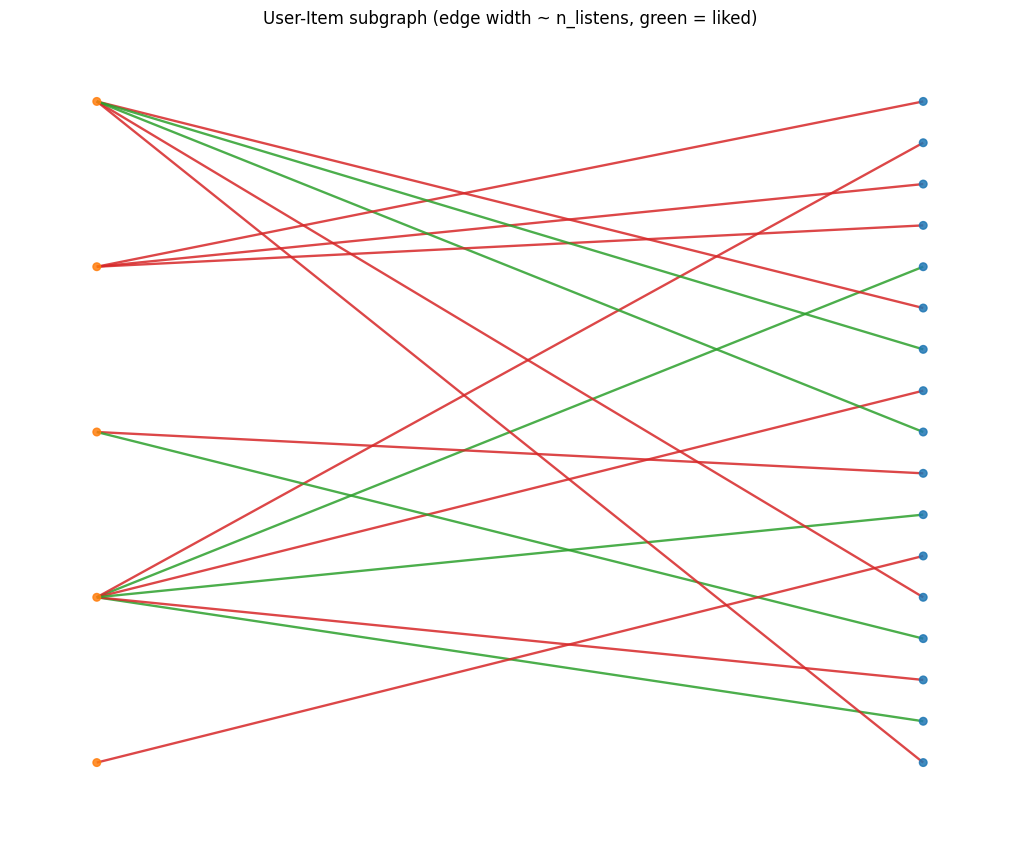

In [23]:
# Finally let's plot our graph
plt.figure(figsize=(10, 8))
nx.draw(S, pos, node_color=node_color, node_size=node_size, width=edge_w,
        edge_color=edge_c, with_labels=False, alpha=0.85)
plt.title("User-Item subgraph (edge width ~ n_listens, green = liked)")
plt.show()

We can see, that some users listen only to small portion of available tracks.
Some of the users tends to dislike tracks, and some of the users tends to like most of the tracks. Later we will explore more interactions between users and items, and also explore relations between item-artist-album-user in future project iterations